In [1]:
# !apt-get update && apt-get install -y graphviz
# !pip install pytz
# !pip install networkx
# !pip install pyyaml
# !pip install graphviz
# !pip install lingam

In [2]:
import time

start = time.time()

In [3]:
import os
import logging
from pytz import timezone
from datetime import datetime
import numpy as np

from data_loader import SyntheticDataset
from models import NoTears
from trainers import ALTrainer
from helpers.config_utils import save_yaml_config, get_train_args
from helpers.log_helper import LogHelper
from helpers.tf_utils import set_seed
from helpers.dir_utils import create_dir
from helpers.analyze_utils import count_accuracy, plot_estimated_graph

# For logging of tensorflow messages
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [4]:
import pandas as pd

exp_name = 'lucas0_train'
dataset_path = '../../experiment/datasets/{}.csv'.format(exp_name)
# true_path = '../../experiment/datasets/{}/W_true.csv'.format(exp_name)

headers = pd.read_csv(dataset_path, nrows=0).columns.tolist()
# df = pd.read_csv(dataset_path, usecols=headers)

df = pd.read_csv(dataset_path)

X = df.to_numpy()

# headers = []
# for i in range(X.shape[1]):
#     headers.append('x{}'.format(i))

df

,Smoking,Yellow_Fingers,Anxiety,Peer_Pressure,Genetics,Attention_Disorder,Born_an_Even_Day,Car_Accident,Fatigue,Allergy,Coughing,Lung_cancer
0,0,0,1,0,0,1,0,1,0,1,0,0
1,0,1,0,0,0,0,1,0,1,0,1,1
2,1,1,1,0,1,1,1,1,1,1,1,1
3,0,0,0,1,0,0,1,0,0,0,0,0
4,1,1,1,0,0,1,1,1,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
1995,0,0,1,0,0,0,0,1,1,0,1,1
1996,1,1,1,0,0,0,0,0,1,0,1,1
1997,1,1,0,1,0,0,1,0,1,0,0,1
1998,1,1,1,0,1,1,0,1,1,0,1,1


In [5]:
# w_true = pd.read_csv(true_path, header=None)

In [6]:
# Get arguments parsed
args = get_train_args()

args.n = X.shape[0]
args.d = X.shape[1]

In [7]:
# Setup for logging
output_dir = 'output/{}/{}'.format(exp_name, datetime.now(timezone('Asia/Taipei')).strftime('%Y-%m-%d_%H-%M-%S-%f')[:-3])
create_dir(output_dir)
LogHelper.setup(log_path='{}/training.log'.format(output_dir), level_str='INFO')
_logger = logging.getLogger(__name__)

# Save the configuration for logging purpose
save_yaml_config(args, path='{}/config.yaml'.format(output_dir))

# Reproducibility
set_seed(args.seed)

# Get dataset
dataset = SyntheticDataset(args.n, args.d, args.graph_type, args.degree, args.sem_type,
                           args.noise_scale, args.dataset_type)
_logger.info('Finished generating dataset')

2022-04-14 11:46:51,718 INFO - helpers.log_helper - Finished configuring logger.
2022-04-14 11:46:51,721 INFO - __main__ - Finished generating dataset


In [8]:
dataset.X = X
X

array([[0, 0, 1, ..., 1, 0, 0],
       [0, 1, 0, ..., 0, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       ...,
       [1, 1, 0, ..., 0, 0, 1],
       [1, 1, 1, ..., 0, 1, 1],
       [1, 1, 0, ..., 1, 1, 1]])

In [9]:
# true answer
# dataset.W = w_true.to_numpy()
# w_true

In [10]:
model = NoTears(args.n, args.d, args.seed, args.l1_lambda, args.use_float64)
model.print_summary(print_func=model.logger.info)

trainer = ALTrainer(args.init_rho, args.rho_max, args.h_factor, args.rho_multiply,
                    args.init_iter, args.learning_rate, args.h_tol)
W_est = trainer.train(model, dataset.X, dataset.W, args.graph_thres,
                      args.max_iter, args.iter_step, output_dir)
_logger.info('Finished training model')

2022-04-14 11:46:52,483 INFO - models.notears - Model summary:
2022-04-14 11:46:52,484 INFO - models.notears - ---------
2022-04-14 11:46:52,484 INFO - models.notears - Variables: name (type shape) [size]
2022-04-14 11:46:52,485 INFO - models.notears - ---------
2022-04-14 11:46:52,485 INFO - models.notears - Variable:0 (float32 12x12) [144, bytes: 576]
2022-04-14 11:46:52,486 INFO - models.notears - Total size of variables: 144
2022-04-14 11:46:52,486 INFO - models.notears - Total bytes of variables: 576
2022-04-14 11:46:52,528 INFO - trainers.al_trainer - Started training for 20 iterations
2022-04-14 11:46:52,529 INFO - trainers.al_trainer - rho 1.000E+00, alpha 0.000E+00
2022-04-14 11:46:56,029 INFO - trainers.al_trainer - [Iter 1] loss 9.388E-01, mse 3.722E+03, acyclic 1.294E-01, shd 25, tpr 0.136, fdr 0.700, pred_size 10
2022-04-14 11:46:56,030 INFO - trainers.al_trainer - rho 1.000E+00, alpha 1.294E-01
2022-04-14 11:46:58,764 INFO - trainers.al_trainer - rho 1.000E+01, alpha 1.29

In [11]:
# Save raw estimated graph, ground truth and observational data after training
# np.save('{}/true_graph.npy'.format(output_dir), dataset.W)
np.save('{}/X.npy'.format(output_dir), dataset.X)
np.save('{}/final_raw_estimated_graph.npy'.format(output_dir), W_est)

In [12]:
W_est

array([[ 0.00000000e+00,  7.46575415e-01,  1.22229524e-01,
         4.47006598e-02,  1.02132559e-04,  1.99499736e-05,
         1.01075256e-02,  3.41052037e-05,  1.85843266e-04,
         3.77335809e-02,  2.26465985e-03,  9.74537852e-06],
       [ 7.43510464e-06,  0.00000000e+00,  4.62141275e-01,
         2.44360596e-01,  3.10953183e-04,  3.08829221e-05,
         8.43642876e-02,  1.64985599e-04,  9.95487906e-04,
         7.70850182e-02,  1.53498268e-02,  3.08626732e-05],
       [ 4.09245258e-05,  4.40737904e-06,  0.00000000e+00,
         7.25429272e-05,  1.35498980e-04,  1.95520232e-04,
         2.59669155e-01,  1.59044785e-03,  1.09383333e-02,
         2.35683266e-02,  1.53037056e-01,  2.17875830e-04],
       [ 7.96181193e-05,  1.04111532e-05,  9.87604335e-02,
         0.00000000e+00,  5.65142545e-05,  4.98745590e-04,
         2.02891201e-01,  3.86739662e-03,  2.52504926e-02,
         4.78551164e-03,  2.15625882e-01,  4.08800872e-04],
       [-2.99472157e-02,  4.63585593e-02,  1.0597434

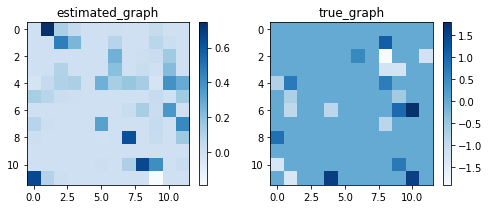

2022-04-14 12:02:11,803 INFO - __main__ - Results: {'fdr': 0.8333333333333334, 'tpr': 1.0, 'fpr': 2.5, 'shd': 66, 'pred_size': 132}


In [23]:
# Plot raw estimated graph
plot_estimated_graph(W_est, dataset.W,
                     save_name='{}/raw_estimated_graph.png'.format(output_dir))

results = count_accuracy(dataset.W, W_est)
_logger.info('Results: {}'.format(results))

# _logger.info('Thresholding.')
graph_thres = 0.3
# # Plot thresholded estimated graph
# args.graph_thres = 0.3
# copy_W_est = np.copy(W_est)
# copy_W_est[np.abs(copy_W_est) < args.graph_thres] = 0   # Thresholding
# plot_estimated_graph(copy_W_est, dataset.W,
#                      save_name='{}/thresholded_estimated_graph.png'.format(output_dir))
# results_thresholded = count_accuracy(dataset.W, copy_W_est)
# _logger.info('Results after thresholding by {}: {}'.format(args.graph_thres, results_thresholded))

In [14]:
end = time.time()

_logger.info('The time used to execute this is given below')
_logger.info(end - start)

2022-04-14 11:47:42,247 INFO - __main__ - The time used to execute this is given below
2022-04-14 11:47:42,248 INFO - __main__ - 52.07948422431946


In [15]:
# c = np.sum(copy_W_est, axis=1)
# c.shape

In [16]:
# copy_W_est

In [17]:
#result_matrix = pd.read_csv("W_true.csv", header=None)

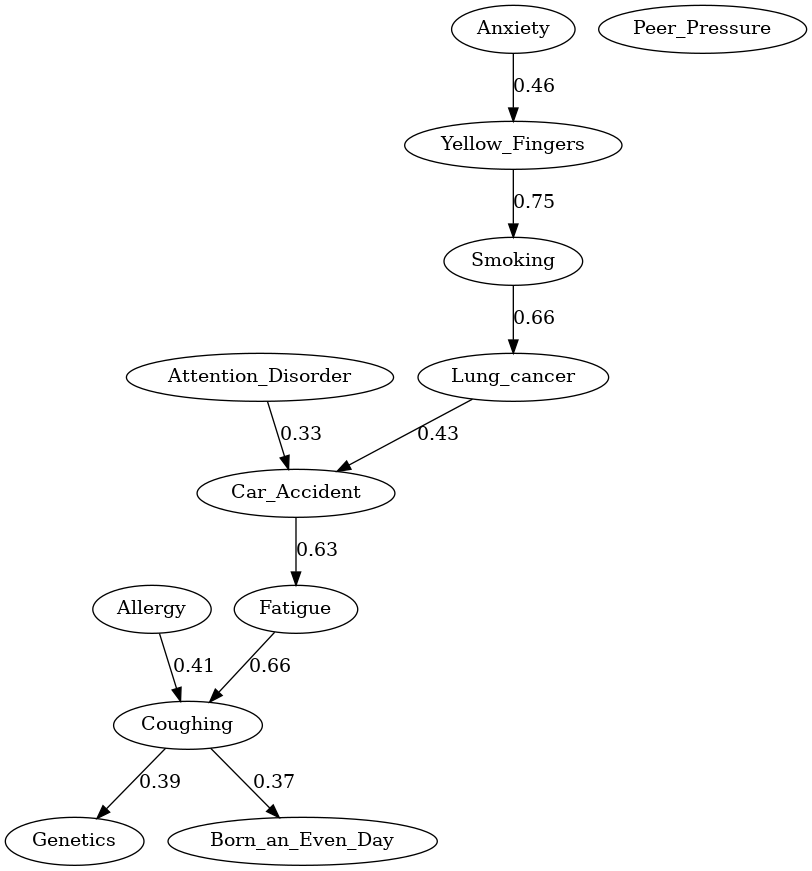

In [24]:
from lingam.utils import make_dot

dot = make_dot(W_est, labels=headers, lower_limit=graph_thres)

# Save png
dot.format = 'png'
dag_path = dot.render('{}/dag'.format(output_dir))

#dot.render('{}/dag'.format(output_dir))

from IPython.display import Image
Image(filename=dag_path) 